# Chest X-Ray Pneumonia Classification – Exploration

## 🎯 Objective
The goal of this notebook is to **explore the cleaned chest X-ray dataset** before modeling.  
We will:
- Load the cleaned metadata (`clean_metadata.csv`)  
- Explore dataset balance and structure  

We will analyze the class distribution, plan how to handle imbalances, and visualize what our data augmentations will look like before we start modeling.

---

## 📂 Dataset
We are using the **cleaned metadata file** generated in the preprocessing step:  
`Data/clean_metadata.csv`  

This ensures we work only with **reliable and standardized images**.

### Import Libraries & Load Metadata

In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.utils import class_weight

# Load the metadata we created in the preprocessing step
df = pd.read_csv("Data/clean_metadata.csv")

print(f"✅ Metadata loaded successfully. Total images: {len(df)}")
df.head()

✅ Metadata loaded successfully. Total images: 5824


,filepath,label,split
0,Data/chest_xray\train\NORMAL\IM-0115-0001.jpeg,NORMAL,train
1,Data/chest_xray\train\NORMAL\IM-0117-0001.jpeg,NORMAL,train
2,Data/chest_xray\train\NORMAL\IM-0119-0001.jpeg,NORMAL,train
3,Data/chest_xray\train\NORMAL\IM-0122-0001.jpeg,NORMAL,train
4,Data/chest_xray\train\NORMAL\IM-0125-0001.jpeg,NORMAL,train


### Analyze Class Distribution

A balanced dataset is key for an unbiased model. Let's check the number of `NORMAL` vs. `PNEUMONIA` cases across our `train`, `val`, and `test` splits.

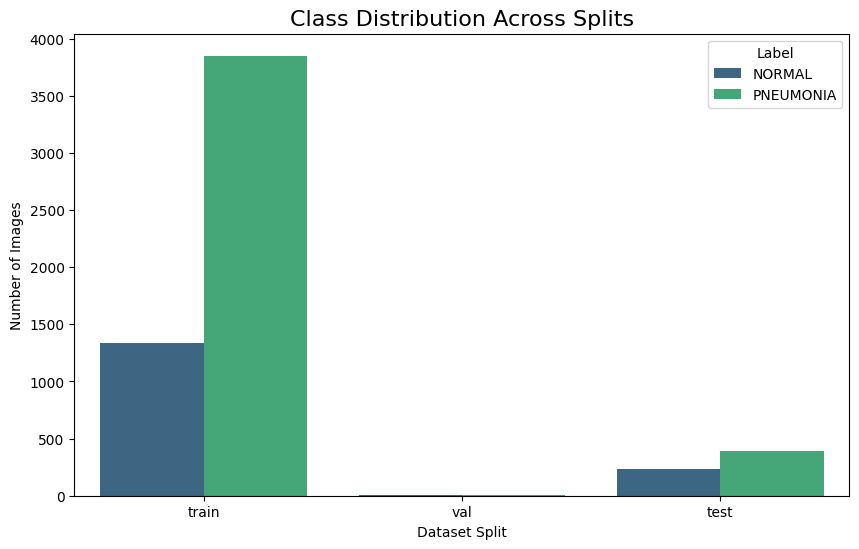

label  NORMAL  PNEUMONIA
split                   
test      231        387
train    1340       3850
val         8          8


In [2]:
# Count samples across splits and labels
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='split', hue='label', palette='viridis')
plt.title("Class Distribution Across Splits", fontsize=16)
plt.ylabel("Number of Images")
plt.xlabel("Dataset Split")
plt.legend(title='Label')
plt.show()

# Print the exact counts
print(df.groupby(['split', 'label']).size().unstack(fill_value=0))


#### Observation: 

The training set has a severe **class imbalance**. There are far more PNEUMONIA images than NORMAL ones. We must address this.

### Plan for Imbalance: Calculate Class Weights

To prevent our model from being biased towards the majority class, we'll use class weights. This technique penalizes the model more for misclassifying the minority class (`NORMAL`).

In [3]:
# Isolate the training data to calculate weights
train_df = df[df['split'] == 'train']

# Calculate class weights using scikit-learn
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

# Keras expects a dictionary mapping class indices to weights
# Let's map NORMAL to 0 and PNEUMONIA to 1
class_map = {'NORMAL': 0, 'PNEUMONIA': 1}
class_weight_dict = {class_map[label]: weight for label, weight in zip(np.unique(train_df['label']), weights)}

print("Labels mapped to indices:", class_map)
print("Calculated Class Weights:", class_weight_dict)
print("\nDuring training, mistakes on 'NORMAL' images will be penalized ~3.8x more than mistakes on 'PNEUMONIA' images.")

Labels mapped to indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Calculated Class Weights: {0: np.float64(1.9365671641791045), 1: np.float64(0.674025974025974)}

During training, mistakes on 'NORMAL' images will be penalized ~3.8x more than mistakes on 'PNEUMONIA' images.


### Visualize Data Augmentations
Data augmentation artificially expands our training set by creating modified copies of images. This helps the model generalize better. Let's visualize what our chosen augmentations will look like.

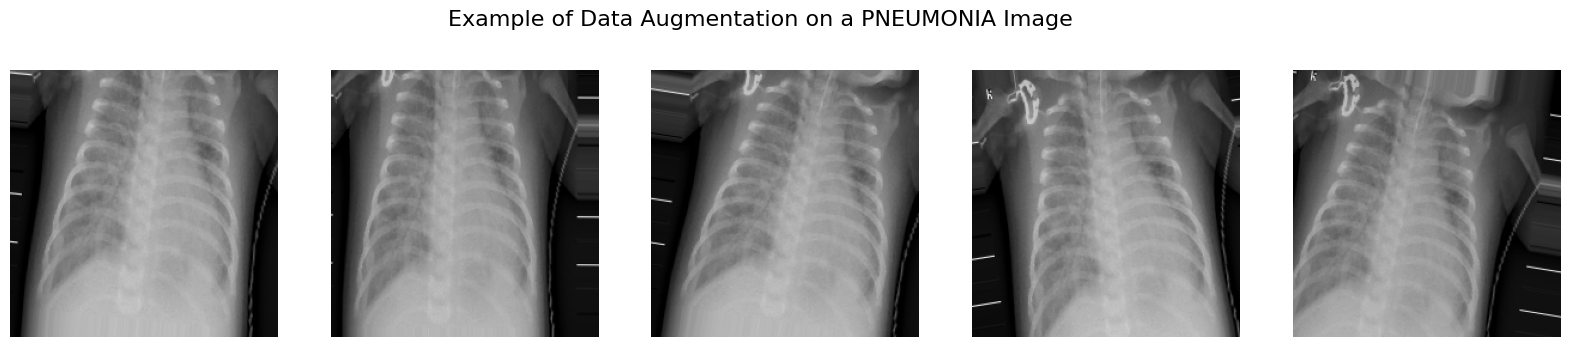

In [4]:
# Define our augmentation strategy in an ImageDataGenerator
aug_gen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=False # Not anatomically correct for X-rays
)

# Pick one sample image to visualize
sample_path = df[df['label'] == 'PNEUMONIA']['filepath'].iloc[0]
img = load_img(sample_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

# Generate and plot 5 augmented versions of the sample image
plt.figure(figsize=(20, 4))
plt.suptitle("Example of Data Augmentation on a PNEUMONIA Image", fontsize=16)
i = 0
for batch in aug_gen.flow(img_array, batch_size=1):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0] / 255.0)
    plt.axis('off')
    i += 1
    if i % 5 == 0:
        break
plt.show()

### Final Sanity Check: Visualize Samples
Finally, let's look at a few random images from each class to ensure our file paths are correct and the labels make sense visually.

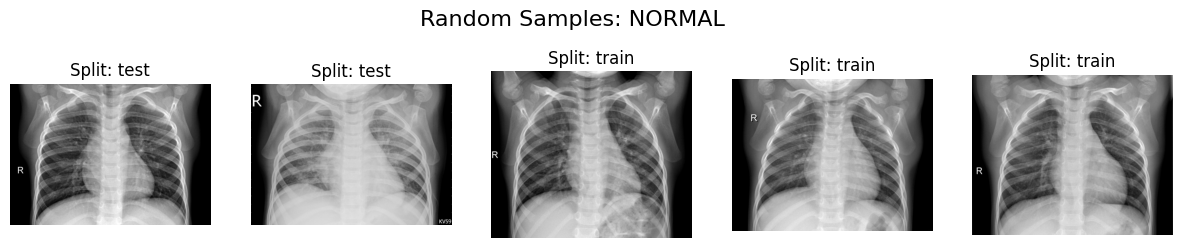

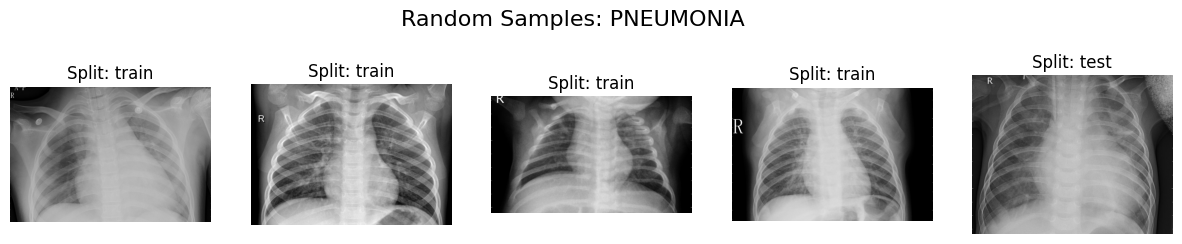

In [5]:
def show_samples(label, n=5):
    """Displays n random samples for a given label."""
    sample_df = df[df['label'] == label].sample(n)
    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Random Samples: {label}', fontsize=16)
    for i, (_, row) in enumerate(sample_df.iterrows()):
        img = load_img(row["filepath"], color_mode="grayscale")
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Split: {row['split']}")
        plt.axis("off")
    plt.show()

# Show samples for both classes
show_samples("NORMAL")
show_samples("PNEUMONIA")

### Conclusion:

Our EDA confirms the dataset is clean and ready. We've identified a class imbalance, calculated weights to correct it, and planned our data augmentation strategy. We're now fully prepared for `03_Model_Building.ipynb`! 🚀